In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import util.normalization as norm
import util.model as models
import util.utility as util

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
df = pd.read_csv("./sample-phone.csv")
df = df.reset_index(names='id')
# df = df.drop(['title', 'body'], axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            100 non-null    int64  
 1   asin          100 non-null    object 
 2   name          100 non-null    object 
 3   rating        100 non-null    int64  
 4   date          100 non-null    object 
 5   verified      100 non-null    bool   
 6   title         100 non-null    object 
 7   body          100 non-null    object 
 8   helpfulVotes  100 non-null    float64
dtypes: bool(1), float64(1), int64(2), object(5)
memory usage: 6.5+ KB
None


,id,asin,name,rating,date,verified,title,body,helpfulVotes
0,0,B07K76LBLZ,PlaYboY BuNnY,5,"February 14, 2019",True,Best phone money can buy,So far this phone is the bees knees.,3.0
1,1,B07P8MQHSH,Gemini_13,3,"August 2, 2019",True,Pixel 3 has frequent display defects,I like this phone model. I bought this phone a...,20.0
2,2,B01NC2MEJP,Kashm30uttz,2,"April 30, 2018",True,the lower left corner of the phone doesnt work...,the lower left corner of the phone doesnt work...,1.0
3,3,B018OMP8ES,Techie241,3,"January 16, 2017",True,"Great phone, be careful with the sellers","The phone is wonderful, if you're considering ...",10.0
4,4,B07QC4R451,Michelle Wildhagen,1,"June 22, 2019",True,U had no issue with the seller they were great...,I was very disappointed in the way this phone ...,3.0


# Normalization

In [4]:
# df_prc = df[['reviewer_id', 'review']].copy()

# # Remove non-ASCII
# df_prc['token_sentence'] = df_prc['review'].apply(norm.remove_non_ascii)

# # Expand contractions
# df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.expand_contractions)

# # Remove characters
# df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.remove_characters, args=(True,))

# # Remove enter tab
# df_prc['token_clean'] = df_prc['token_sentence'].apply(norm.remove_enter_tab)

# # Lemmatization
# df_prc['token_clean'] = df_prc['token_clean'].apply(norm.lemmatize_text)

In [5]:
# Tokenization into sentence

df_st = df.copy()
df_st['review'] = df_st['title'] + ". " + df_st['body']

df_st = df_st[['id', 'review']]

# Remove non-ASCII
df_st['token_sentence'] = df_st['review'].apply(norm.remove_non_ascii)

# Sentence Tokenization
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

# Get Aspect (Rules Based)

In [6]:
# Get aspect from rules
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean']\
                        .progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 972/972 [01:33<00:00, 10.36it/s]


In [7]:
from transformers import pipeline

classifier = pipeline("summarization")

def get_summarize(text, min_length=25, max_length=48):
    try:
        result = classifier(text, min_length=min_length, max_length=max_length)
        if result and len(result) > 0:
            return result[0]['summary_text']
        else:
            return "Summary could not be generated"
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return "Summary error"

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
df_st.head()

,id,review,token_sentence,token_clean,sub_aspect
0,0,Best phone money can buy. So far this phone is...,Best phone money can buy.,best phone money can buy .,"{best phone, money best, phone money}"
0,0,Best phone money can buy. So far this phone is...,So far this phone is the bees knees.,so far this phone be the bee knee .,"{phone, bee knee}"
1,1,Pixel 3 has frequent display defects. I like t...,Pixel 3 has frequent display defects.,pixel 3 have frequent display defect .,"{frequent display, pixel, display defect}"
1,1,Pixel 3 has frequent display defects. I like t...,I like this phone model.,i like this phone model .,{phone model}
1,1,Pixel 3 has frequent display defects. I like t...,I bought this phone as a gift to my wife.,i buy this phone as a gift to my wife .,{phone}


In [9]:
# Create summary
mask = df_st['sub_aspect'].apply(lambda x: False if len(x) == 0 else True).values

df_summary = df_st[mask].groupby(['id'])['token_sentence']\
                .apply(lambda x: '\n'.join([f"- {item}" for item in x]))\
                .reset_index()\
                .rename(columns={'token_sentence': 'summary_point'})

df_prc = df_st.groupby(['id'])\
                .agg({'sub_aspect': lambda x: set().union(*x),
                      'token_clean': lambda x: '. '.join(x),
                     })\
                .reset_index()

df_prc = df_prc.merge(df_summary, on='id', how='left').fillna("")

# Get summarize
tqdm.pandas()
df_prc['summary'] = df_prc['token_clean'].progress_apply(lambda x: get_summarize(x))
print(df_prc.info())
df_prc.head()

 63%|███████████████████████████████████████████████████                              | 63/100 [04:36<02:11,  3.55s/it]Your max_length is set to 48, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Error summarizing text: index out of range in self


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:23<00:00,  4.43s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             100 non-null    int64 
 1   sub_aspect     100 non-null    object
 2   token_clean    100 non-null    object
 3   summary_point  100 non-null    object
 4   summary        100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB
None


,id,sub_aspect,token_clean,summary_point,summary
0,0,"{best phone, phone, money best, bee knee, phon...",best phone money can buy .. so far this phone ...,- Best phone money can buy.\n- So far this pho...,Best phone money can buy .. so far this phone...
1,1,"{frequent display, amazon, pink tint, phone mo...",pixel 3 have frequent display defect .. i like...,- Pixel 3 has frequent display defects.\n- I l...,pixel 3 have frequent display defect .. i lik...
2,2,"{leave corner, low leave, phone, money sick}",the low leave corner of the phone doesnt work ...,- the lower left corner of the phone doesnt wo...,the low leave corner of the phone does not wo...
3,3,"{positive click, phone, volume button, seller,...",great phone. be careful with the seller .. the...,- Great phone\n- The phone is wonderful\n- How...,Seller marks seller's phone as ''like new '' ...
4,4,"{issue, nice photo, phone work, drop call, ser...",u have no issue with the seller they be great ...,- U had no issue with the seller they were gre...,i be very disappointed in the way this phone ...


In [10]:
# # Get aspect from rules
# tqdm.pandas()
# df_prc['sub_aspect'] = df_prc['token_clean']\
#                         .progress_apply(util.get_aspect_rules)

In [11]:
# print(df_prc.info())
# df_prc.head()

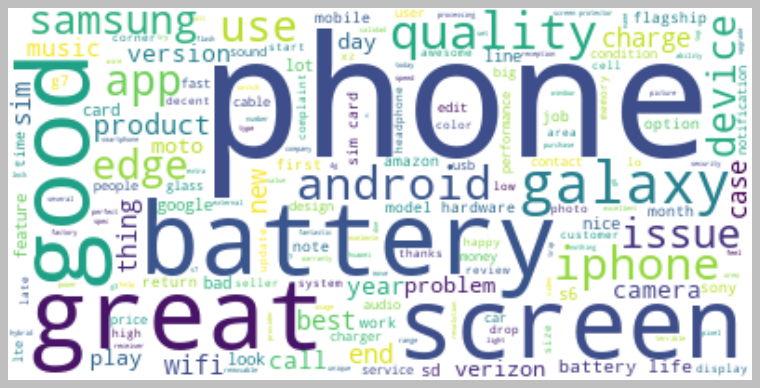

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_prc['sub_aspect'].values
for i in range(df_prc.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
# df['sub_aspect'] = df_prc['sub_aspect'].apply(lambda x: ", ".join(list(x)))

# Get Topic

In [14]:
def get_optimum_lda(dictionary, corpus, texts, limit,
                    start=2, step=1, get_result=False,
                    iterations=20, passes=1):
    coherence_values = []
    
    for n in range(start, limit, step):
        lda = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=n,
                                         id2word=dictionary,
                                         iterations=iterations,
                                         passes=passes)
        
        # Create coherence
        coherence_model = CoherenceModel(model=lda, 
                                         texts=texts,
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    
    opt_num_topics = start + coherence_values.index(max(coherence_values))
    
    lda_opt = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=opt_num_topics,
                                         id2word=dictionary)
    
    if get_result:
        print(coherence_values)
    
    return lda_opt



In [15]:
import gensim
from gensim.models import CoherenceModel


texts = df_prc['token_clean'].apply(norm.preprocess_lda)

dictionary = gensim.corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100_000)
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

lda_opt = get_optimum_lda(dictionary, bow_corpus,
                          texts, 10, get_result=True,
                          passes=50, iterations=100)

[0.2409174736265154, 0.2409174736265154, 0.2409174736265154, 0.2409174736265154, 0.2409174736265154, 0.2409174736265154, 0.2409174736265154, 0.24091747362651544]


In [16]:
# Print topic
for idx, topic in lda_opt.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.265*"work" + 0.254*"battery" + 0.193*"great" + 0.115*"screen" + 0.060*"samsung" + 0.043*"good" + 0.042*"issue" + 0.028*"iphone"
Topic: 1 
Words: 0.384*"good" + 0.384*"iphone" + 0.039*"great" + 0.039*"screen" + 0.039*"work" + 0.039*"samsung" + 0.039*"battery" + 0.039*"issue"
Topic: 2 
Words: 0.314*"great" + 0.214*"good" + 0.213*"screen" + 0.112*"iphone" + 0.112*"issue" + 0.011*"samsung" + 0.011*"battery" + 0.011*"work"
Topic: 3 
Words: 0.346*"great" + 0.262*"good" + 0.145*"battery" + 0.116*"screen" + 0.065*"samsung" + 0.045*"work" + 0.020*"issue" + 0.002*"iphone"
Topic: 4 
Words: 0.209*"good" + 0.209*"samsung" + 0.209*"screen" + 0.142*"great" + 0.142*"iphone" + 0.075*"battery" + 0.008*"work" + 0.007*"issue"
Topic: 5 
Words: 0.286*"good" + 0.285*"iphone" + 0.285*"issue" + 0.029*"great" + 0.029*"samsung" + 0.029*"work" + 0.029*"screen" + 0.029*"battery"
Topic: 6 
Words: 0.312*"issue" + 0.267*"good" + 0.177*"samsung" + 0.129*"great" + 0.068*"iphone" + 0.021*"work" + 0.01

In [17]:
def predict_topic(text):
    text = util.preprocess_lda(text)
    bow_vector = dictionary.doc2bow(text)
    
    result = sorted(lda_opt[bow_vector], 
                    key=lambda x: -1*x[1])[0][0]
    
    return result
    
# Extract keywords into a dictionary or list
threshold = 0.1
topics_dict = {}
for topic_num, topic in lda_opt.show_topics(num_topics=10,
                                                num_words=10,
                                                formatted=False):
    keywords = [word for word, w in topic if w > threshold]
    topics_dict[topic_num] = keywords

In [18]:
topics_dict

{0: ['work', 'battery', 'great', 'screen'],
 1: ['good', 'iphone'],
 2: ['great', 'good', 'screen', 'iphone', 'issue'],
 3: ['great', 'good', 'battery', 'screen'],
 4: ['good', 'samsung', 'screen', 'great', 'iphone'],
 5: ['good', 'iphone', 'issue'],
 6: ['issue', 'good', 'samsung', 'great'],
 7: ['samsung', 'iphone', 'screen', 'great'],
 8: ['good', 'battery', 'iphone', 'issue']}

In [19]:
df = df.merge(df_prc[['id', 'sub_aspect', 'summary' ,'summary_point']], on='id', how='left', )

In [20]:
tqdm.pandas()
df['topic'] = df_prc['token_clean'].progress_apply(predict_topic)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.51it/s]


In [21]:
tqdm.pandas()
df['key_topic'] = df['topic']\
                    .progress_apply(lambda x: ", ".join(topics_dict[x]))

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


In [22]:
tqdm.pandas()
df['sub_aspect'] = df['sub_aspect']\
                    .progress_apply(lambda x: ", ".join(list(x)))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 19689.72it/s]


In [23]:
df.head()

,id,asin,name,rating,date,verified,title,body,helpfulVotes,sub_aspect,summary,summary_point,topic,key_topic
0,0,B07K76LBLZ,PlaYboY BuNnY,5,"February 14, 2019",True,Best phone money can buy,So far this phone is the bees knees.,3.0,"best phone, phone, money best, bee knee, phone...",Best phone money can buy .. so far this phone...,- Best phone money can buy.\n- So far this pho...,0,"work, battery, great, screen"
1,1,B07P8MQHSH,Gemini_13,3,"August 2, 2019",True,Pixel 3 has frequent display defects,I like this phone model. I bought this phone a...,20.0,"frequent display, amazon, pink tint, phone mod...",pixel 3 have frequent display defect .. i lik...,- Pixel 3 has frequent display defects.\n- I l...,2,"great, good, screen, iphone, issue"
2,2,B01NC2MEJP,Kashm30uttz,2,"April 30, 2018",True,the lower left corner of the phone doesnt work...,the lower left corner of the phone doesnt work...,1.0,"leave corner, low leave, phone, money sick",the low leave corner of the phone does not wo...,- the lower left corner of the phone doesnt wo...,0,"work, battery, great, screen"
3,3,B018OMP8ES,Techie241,3,"January 16, 2017",True,"Great phone, be careful with the sellers","The phone is wonderful, if you're considering ...",10.0,"positive click, phone, volume button, seller, ...",Seller marks seller's phone as ''like new '' ...,- Great phone\n- The phone is wonderful\n- How...,3,"great, good, battery, screen"
4,4,B07QC4R451,Michelle Wildhagen,1,"June 22, 2019",True,U had no issue with the seller they were great...,I was very disappointed in the way this phone ...,3.0,"issue, nice photo, phone work, drop call, serv...",i be very disappointed in the way this phone ...,- U had no issue with the seller they were gre...,0,"work, battery, great, screen"


In [24]:
df.to_csv('result_phone.csv', index=False)